In [24]:
#utils
import pandas as pd
import pandas_datareader as pdr
import numpy as np 
import matplotlib.pyplot as plt 
import IPython.core.display
import datetime as dt
import statistics 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import dateutil.parser

#plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from plotly import tools

#models
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge
import sklearn
import pandas_datareader.data as web
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from pandas_datareader.data import DataReader
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')



In [25]:
#Read in our bitcoin data from year 2016 (about 28k entries)
df = pd.read_csv('coins.csv')

#Convert ISO 8601 timestamp to datetime
df.index = df['time_period_end']
df.index = pd.to_datetime(df['time_period_end'])

#Drop columns that we do not need
columns = ['Unnamed: 0','time_close', 'time_period_start', 'time_open', 'time_period_end', 'volume_traded', 'trades_count']
df.drop(columns, inplace=True, axis=1)


In [26]:
df.tail()

,price_open,price_high,price_low,price_close
time_period_end,,,,
2019-09-10 05:00:00+00:00,9345.56,9364.80,9311.42,9341.52
2019-09-10 06:00:00+00:00,9341.56,9341.56,9285.06,9300.13
2019-09-10 07:00:00+00:00,9314.82,9317.08,9270.30,9312.47
2019-09-10 08:00:00+00:00,9298.08,9338.43,9273.86,9317.55
2019-09-10 09:00:00+00:00,9309.33,9334.02,9293.19,9302.79


### OHLC Average feature

Average of all prices



In [27]:
df['ohlc_average'] = (df['price_open'] + df['price_high'] + df['price_low'] + df['price_close']) / len(df.columns)


In [28]:
df.tail(10)


,price_open,price_high,price_low,price_close,ohlc_average
time_period_end,,,,,
2019-09-10 00:00:00+00:00,9374.46,9400.39,9342.38,9353.57,9367.7000
2019-09-10 01:00:00+00:00,9351.12,9400.89,9340.00,9380.83,9368.2100
2019-09-10 02:00:00+00:00,9371.30,9410.62,9371.22,9375.35,9382.1225
2019-09-10 03:00:00+00:00,9382.59,9397.51,9311.40,9330.33,9355.4575
2019-09-10 04:00:00+00:00,9321.34,9346.48,9293.23,9345.56,9326.6525
2019-09-10 05:00:00+00:00,9345.56,9364.80,9311.42,9341.52,9340.8250
2019-09-10 06:00:00+00:00,9341.56,9341.56,9285.06,9300.13,9317.0775
2019-09-10 07:00:00+00:00,9314.82,9317.08,9270.30,9312.47,9303.6675
2019-09-10 08:00:00+00:00,9298.08,9338.43,9273.86,9317.55,9306.9800


# Normalizing the data

### Function to normalize each column, parameters take a dataframe and a specific column

We use the min-max normalize scale function to get a more accurate result as the values are all between 0 and 1.

In [29]:
def normalizeColumn(df, column):
    x = df[column].values #returns a numpy array
    scaler = preprocessing.minmax_scale(x)
    return scaler

### Function to normalize each column separately

In [30]:
def normalizeDf(df):
    
    normalizedDf = pd.DataFrame()
    
    for column in df:
        normalizedDf[column] = normalizeColumn(df, column)
               
    return normalizedDf.set_index(df.index)

In [31]:
#replace all infinity values with nan
df = df.replace([np.inf, -np.inf], np.nan)

#create our normalized dataframe using the normalizeDf function that we created
normalizedDataFrame = normalizeDf(df)


### We shift the closeprice to make a LABEL column for us, which we then  predict on.

## !!! We should not shift the price before we normalize the values, else the values will be wrong!

In [32]:
#Shift close to create our label, also dropping NaN values
normalizedDataFrame['label'] = normalizedDataFrame['price_close'].shift(-1)
normalizedDataFrame = normalizedDataFrame.dropna()

### Splitting the dataframe into test/train

In [33]:
#We print them next to eachother to check that our label is correct.
normalizedDataFrame[['price_close', 'label']].tail(5)

,price_close,label
time_period_end,,
2019-09-10 04:00:00+00:00,0.559256,0.559004
2019-09-10 05:00:00+00:00,0.559004,0.556421
2019-09-10 06:00:00+00:00,0.556421,0.557191
2019-09-10 07:00:00+00:00,0.557191,0.557508
2019-09-10 08:00:00+00:00,0.557508,0.556587


In [34]:
#We split the dataframes to create our test and train dataframes
n = normalizedDataFrame.shape[0]
train_size = 0.8
train_dataframe = normalizedDataFrame.iloc[:int(n * train_size)]
test_dataframe = normalizedDataFrame.iloc[int(n * train_size):]

print("Amount of traindata rows: ", len(train_dataframe),'\n'
      "Amount of testdata rows: ", len(test_dataframe))
print("Rows in total:", len(normalizedDataFrame))


Amount of traindata rows:  22792 
Amount of testdata rows:  5699
Rows in total: 28491


## Using SVR, RandomForest, LinearRegression and MLP

In [35]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

#regressionmodels
svr = SVR()
rf = RandomForestRegressor()
lr = LinearRegression()
mlp = MLPRegressor()

#We create our x and y train values
x_train = np.array(train_dataframe[['price_close', 'ohlc_average']])
y_train = np.array(train_dataframe['label'])

#and then we use our training data on the models
svr.fit(x_train, y_train)
lr.fit(x_train, y_train)
rf.fit(x_train, y_train)
mlp.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
#We define our test values
x_test = np.array(test_dataframe[['price_close', 'ohlc_average']])
y_test = np.array(test_dataframe['label'])

#Show the accuracy on our test values
print("svr score:", svr.score(x_test, y_test))
print("lr score:", lr.score(x_test, y_test))
print("rf score:", rf.score(x_test, y_test))
print("mlp score:", mlp.score(x_test, y_test))

svr score: 0.9878724940875493
lr score: 0.9994163885880367
rf score: 0.9990062421638006
mlp score: 0.999350150817905


## Creating a decision

##### The decision function creates a True = buy, False = sell decision based on our predicted values. 

##### Basically the function simply compares the forecast with our price close, if the forecast value is bigger then we want to buy, else we sell.

##### The actual decision compares label with price_close.

##### We can then compare the actual with our forecasted decision to figure out our hit/miss percentage using our hit_miss function.

##### With the hit/miss function we can see which model is has the highest percentage


In [37]:
#decision function. if forecast value is higher than close = buy, else sell
def decision(model, df, x_test, model_name):
    df['actual'] = (df.label > df.price_close)
    df[model_name + '_forecast'] = model.predict(x_test)
    df[model_name + '_decision'] = (df[model_name + '_forecast'] > df.price_close) # True == buy, False == sell  
    return df

#hit_miss function, basically checks how many times our models are the same as actual, giving us a percentage of hits
def hit_miss(df, model_name):
    df[model_name + '_hitmiss'] = (df.actual == df[model_name + '_decision'])
    print('Hit miss percentage', model_name,':', (df[model_name + '_hitmiss'].values == True).sum() / len(df), '%')
    

In [38]:
#creating our decision columns into the test_dataframe
decision(lr, test_dataframe, x_test, 'lr')
decision(mlp, test_dataframe, x_test, 'mlp')
decision(rf, test_dataframe, x_test, 'rf')
decision(svr, test_dataframe, x_test, 'svr')

,price_open,price_high,price_low,price_close,ohlc_average,label,actual,lr_forecast,lr_decision,mlp_forecast,mlp_decision,rf_forecast,rf_decision,svr_forecast,svr_decision
time_period_end,,,,,,,,,,,,,,,
2019-01-15 18:00:00+00:00,0.175756,0.175606,0.194549,0.175643,0.176225,0.175784,True,0.175667,True,0.175141,False,0.175517,False,0.207455,True
2019-01-15 19:00:00+00:00,0.176022,0.175579,0.194647,0.175784,0.176345,0.175654,False,0.175806,True,0.175275,False,0.175351,False,0.207552,True
2019-01-15 20:00:00+00:00,0.175819,0.175343,0.194462,0.175654,0.176155,0.172014,False,0.175670,True,0.175127,False,0.175313,False,0.207433,True
2019-01-15 21:00:00+00:00,0.175282,0.175094,0.190269,0.172014,0.173981,0.172079,True,0.172170,True,0.171967,False,0.171986,False,0.205268,True
2019-01-15 22:00:00+00:00,0.171514,0.171964,0.190949,0.172079,0.172436,0.172444,True,0.172084,True,0.171535,False,0.171207,False,0.204719,True
2019-01-15 23:00:00+00:00,0.172111,0.172314,0.191401,0.172444,0.172880,0.172478,True,0.172455,True,0.171921,False,0.172222,False,0.205019,True
2019-01-16 00:00:00+00:00,0.172138,0.172315,0.191626,0.172478,0.172953,0.173144,True,0.172493,True,0.171967,False,0.172200,False,0.205058,True
2019-01-16 01:00:00+00:00,0.172509,0.172584,0.191471,0.173144,0.173242,0.172988,False,0.173123,False,0.172512,False,0.173789,True,0.205413,True
2019-01-16 02:00:00+00:00,0.173011,0.172931,0.191970,0.172988,0.173542,0.172782,False,0.173010,True,0.172498,False,0.172219,False,0.205467,True


In [39]:
#Hit/Miss percentages.. basically how many times our forecast is right
hit_miss(test_dataframe, 'mlp')
hit_miss(test_dataframe, 'lr')
hit_miss(test_dataframe, 'rf')
hit_miss(test_dataframe, 'svr')

Hit miss percentage mlp : 0.48341814353395335 %
Hit miss percentage lr : 0.5536058957711879 %
Hit miss percentage rf : 0.5086857343393578 %
Hit miss percentage svr : 0.5318476925776452 %


## Plotting our forecasts with label

I've plotted all forecast models with my label to visualize all of the models

In [40]:
#plotting the forecasts and label
line1 = go.Scatter( x=test_dataframe.index, y=test_dataframe.mlp_forecast, name='MLP' )
line2 = go.Scatter( x=test_dataframe.index, y=test_dataframe.svr_forecast, name='SVR' )
line3 = go.Scatter( x=test_dataframe.index, y=test_dataframe.rf_forecast, name='RF' )
line4 = go.Scatter( x=test_dataframe.index, y=test_dataframe.lr_forecast, name='LR')
line5 = go.Scatter( x=test_dataframe.index, y=test_dataframe.label, name='Label' )

layout = go.Layout(
    title='Prediction',
    yaxis=dict(title='Price normalized'),
    xaxis=dict(title='Date')
)

data = [line1, line2, line3, line4, line5]

fig = go.Figure(data=data, layout=layout)

iplot(fig)

## sMAPE and MASE calculations

### SMAPE - symmetric mean absolute percentage error

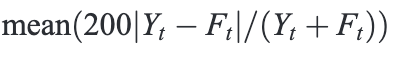

In [41]:
#this function is based on the formula shown above, which is from the paper/article found on itslearning "ErrorMeasurements.pdf"
def my_smape(label, forecast):
    return np.mean(200*(np.abs(label - forecast) / (label + forecast)))


#this function is striaght up copied from the internet (so i can test whether my own one gives same result)
def smape(label, forecast):
    return 100/len(label) * np.sum(2 * np.abs(forecast - label) / (np.abs(label) + np.abs(forecast)))

In [42]:
print("sMAPE for SVR:", my_smape(test_dataframe['label'], test_dataframe['svr_forecast']))
print("sMAPE for RandomForest:", my_smape(test_dataframe['label'], test_dataframe['rf_forecast']))
print("sMAPE for lr:", my_smape(test_dataframe['label'], test_dataframe['lr_forecast']))
print("sMAPE for MLP:", my_smape(test_dataframe['label'], test_dataframe['mlp_forecast']))


sMAPE for SVR: 6.15753054506314
sMAPE for RandomForest: 0.7655015219552334
sMAPE for lr: 0.4745396963440281
sMAPE for MLP: 0.5633176977022696


### MASE - mean absolute scaled error


In [43]:
def mase(actual, predicted):
    #return np.mean(np.abs(actual - predicted)) / np.mean(np.abs(actual[1:] - actual[:-1]))
    
    #predicted error mean / naive prediction error mean
    return np.mean(np.abs(actual - predicted)) / np.mean(np.abs(np.diff(actual)))

In [44]:
print("MASE for SVR:", mase(test_dataframe['label'], test_dataframe['svr_forecast']))
print("MASE for RandomForest:", mase(test_dataframe['label'], test_dataframe['rf_forecast']))
print("MASE for lr:", mase(test_dataframe['label'], test_dataframe['lr_forecast']))
print("MASE for MLP:", mase(test_dataframe['label'], test_dataframe['mlp_forecast']))

MASE for SVR: 6.754770568210163
MASE for RandomForest: 1.5257335273424801
MASE for lr: 0.9955110351550303
MASE for MLP: 1.1329717673550954


## We create a dataframe to display the comparison between our results from SMAPE and MASE

From the table below we can clearly see that the LinearRegression give us the "least" error.

In [45]:
# Insert data for SMAPE and MASE
data = {'SMAPE':[my_smape(test_dataframe['label'], test_dataframe['svr_forecast']),
                my_smape(test_dataframe['label'], test_dataframe['rf_forecast']),
                my_smape(test_dataframe['label'], test_dataframe['lr_forecast']),
                my_smape(test_dataframe['label'], test_dataframe['mlp_forecast'])],
        
        'MASE': [mase(test_dataframe['label'], test_dataframe['svr_forecast']), 
                 mase(test_dataframe['label'], test_dataframe['rf_forecast']), 
                 mase(test_dataframe['label'], test_dataframe['lr_forecast']), 
                 mase(test_dataframe['label'], test_dataframe['mlp_forecast'])], } 
  
# create a dataframe with our values 
rankingDF = pd.DataFrame(data, index = ['SVR', 'RF', 'LR', 'MLP'])
rankingDF

,SMAPE,MASE
SVR,6.157531,6.754771
RF,0.765502,1.525734
LR,0.474540,0.995511
MLP,0.563318,1.132972
